# Too large step sizes can lead to geometrical differences at the population level

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import scipy.integrate as scpi

import cbmos_serial as cbmos
import force_functions as ff
import euler_forward as ef
import adams_bashforth as ab
import midpoint as md
import heun as he
import cell as cl

plt.style.use('seaborn-whitegrid')
plt.style.use('tableau-colorblind10')
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (6.75, 5),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [2]:
# plot function
def plot_population(cell_list, color='blue'):
    fig=plt.figure()
    ax=fig.add_subplot(1,1,1)
    #colors = 10*plt.rcParams['axes.prop_cycle'].by_key()['color']
    n_cells = len(cell_list)
    for i in range(n_cells):
        #ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=colors[i], alpha=0.6))
        ax.add_patch(plt.Circle(cell_list[i].position ,0.5,color=color, alpha=0.4))
        plt.plot(cell_list[i].position[0], cell_list[i].position[1], '.', color=color)
    #plt.show()
    return fig

In [3]:
# calculate radius
def calculate_radius(cell_list):
    n_cells = len(cell_list)
    positions = np.array([cell.position for cell in cell_list])
    c = np.sum(positions, axis=0)/n_cells
    return 0.5 + max([np.linalg.norm(cell.position - c) for cell in cell_list])

In [4]:
# Simulation parameters
s = 1.0    # rest length
tf = 10.0  # final time
rA = 1.5   # maximum interaction distance
dim = 2
seed=67
t_data = np.linspace(0, tf, int(100*tf)+1)
n = 20


In [5]:


solver_names = ['EF', 'AB', 'midpoint', 'Heun']
force_names = ['cubic', 'pw. quad.', 'GLS']

defcolors = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = {'cubic': defcolors[0], 'pw. quad.': defcolors[5], 'GLS': defcolors[3]}
colors_list = [defcolors[0], defcolors[0], defcolors[0]]

In [6]:
# Solvers
solvers_ef = {'pw. quad.': cbmos.CBMSolver(ff.piecewise_polynomial, ef.solve_ivp, dim), 
             'cubic': cbmos.CBMSolver(ff.cubic, ef.solve_ivp, dim),
             'GLS': cbmos.CBMSolver(ff.gls, ef.solve_ivp, dim)}


## Initial condition

In [7]:
# 2D honeycomb mesh
n_x = 5
n_y = 5
xcrds = [(2 * i + (j % 2)) * 0.5 for j in range(n_y) for i in range(n_x)]
ycrds = [np.sqrt(3) * j * 0.5 for j in range(n_y) for i in range(n_x)]

# make cell_list for the sheet
initial_sheet = [cl.Cell(i, [x,y], -24.0, True, lambda t: 24+t) for i, x, y in zip(range(n_x*n_y), xcrds, ycrds)]
# delete cells to make it circular
del initial_sheet[24]
del initial_sheet[20]
del initial_sheet[19]
del initial_sheet[9]
del initial_sheet[4]
del initial_sheet[0]

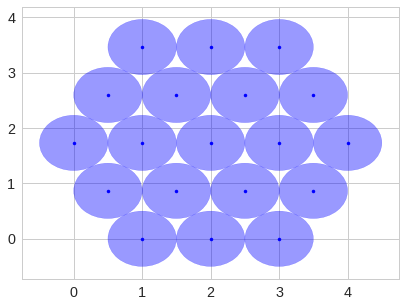

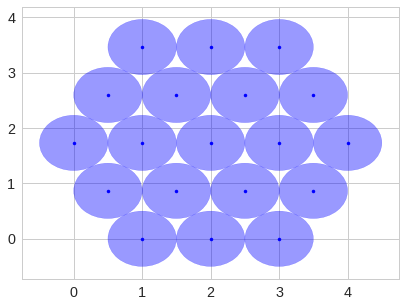

In [8]:
# plot to check what happend
plot_population(initial_sheet)

In [9]:
#prepare consistent initial data
solver_scipy = cbmos.CBMSolver(ff.piecewise_polynomial, scpi.solve_ivp, dim)
t_data_init = [0, 0.0001]
sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=seed)[-1]



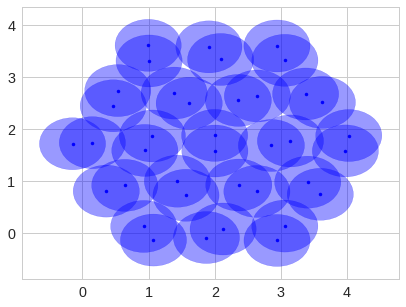

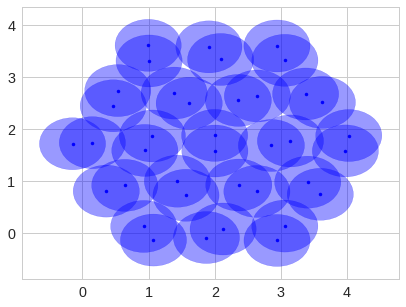

In [10]:
# plot to check what happend
plot_population(sheet)

# Using parameters fitted to relaxation time

In [11]:
params_cubic = {"mu": 5.70, "s": s, "rA": rA}
muR = 9.1
ratio = 0.21
params_poly = {'muA': ratio*muR, 'muR': muR, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(ratio)/3.0), 'n': 1.0, 'p': 1.0}
mu_gls=1.95
params_gls = {'mu': mu_gls, 'a':-2*np.log(0.002/mu_gls)}
params = {'cubic': params_cubic, 'pw. quad.': params_poly, 'GLS': params_gls}

## Plot the sheet for different dt values

In [12]:
dt_values = [0.005, 0.075, 0.1]

In [13]:
pop_t_end = {'cubic': [], 'pw. quad.': [], 'GLS': []}
t_data_values = {}
for dt in dt_values:
    N = int(1/dt*tf) + 1
    #print([ N, dt])
    #t_data = np.linspace(0,1,N)
    t_data = np.arange(0,tf,dt)
    t_data_values[dt] = t_data
    for force in force_names:
        history = solvers_ef[force].simulate(sheet, t_data, params[force], {'dt': dt}, seed=seed)
        pop_t_end[force].append(history[-1])




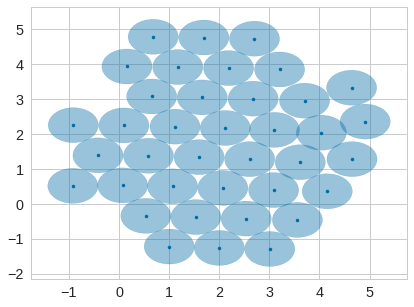

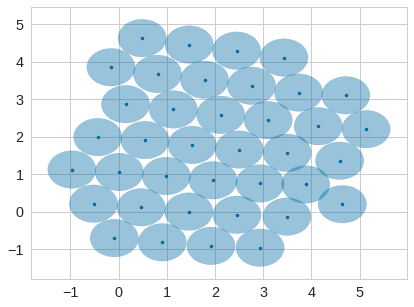

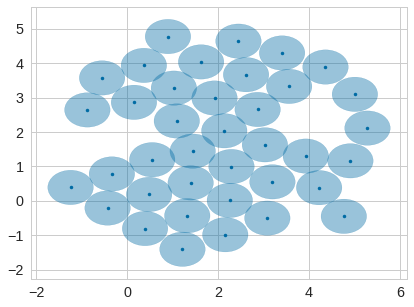

In [14]:
for i, dt in enumerate(dt_values):
    fig = plot_population(pop_t_end['cubic'][i], color=colors['cubic'])
    fig.savefig('pop_cubic_'+str(dt).replace('.', '_')+'.pdf')

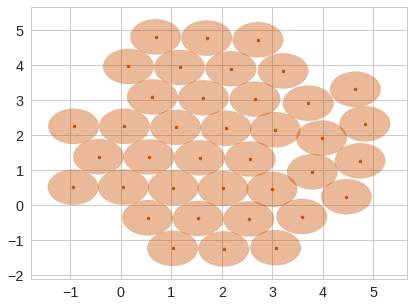

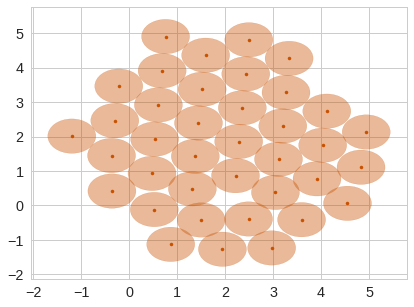

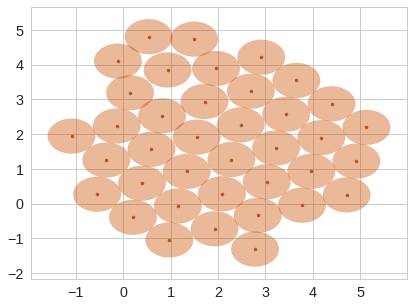

In [15]:
for i, dt in enumerate(dt_values):
    fig = plot_population(pop_t_end['pw. quad.'][i], color=colors['pw. quad.'])
    fig.savefig('pop_pw_quad_'+str(dt).replace('.', '_')+'.pdf')

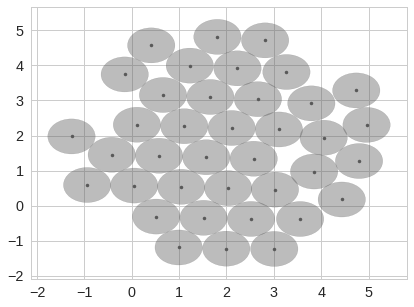

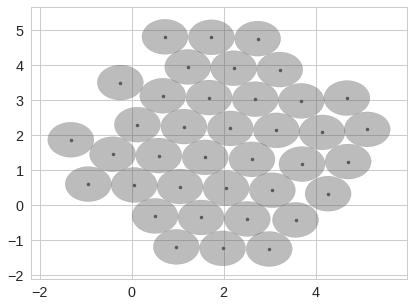

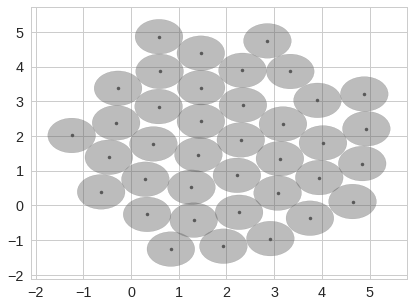

In [16]:
for i, dt in enumerate(dt_values):
    fig = plot_population(pop_t_end['GLS'][i], color=colors['GLS'])
    fig.savefig('pop_GLS_'+str(dt).replace('.', '_')+'.pdf')

## Get statistics on radii with more random seeds

In [17]:
radii = {'cubic': {}, 'pw. quad.': {}, 
         'GLS': {}}
for force in force_names:
    for dt in dt_values:
        t_data = np.arange(0,tf,dt)
        radii[force][dt] = np.zeros(len(t_data))
        
n = 15
for a in range(0,n):
    #prepare consistent initial data 
    sheet = solver_scipy.simulate(initial_sheet, t_data_init, {'muA': 0.21*9.1, 'muR': 9.1, 'rA': rA, 'rR': 1.0/(1.0-np.sqrt(0.21)/3.0), 'n': 1.0, 'p': 1.0}, {}, seed=a)[-1]
    
    for dt in dt_values:
        N = int(1/dt*tf) + 1
        #print([ N, dt])
        #t_data = np.linspace(0,1,N)
        t_data = np.arange(0,tf,dt)
    
        for force in force_names:
            history = solvers_ef[force].simulate(sheet, t_data, params[force], {'dt': dt}, seed=a)
            radii[force][dt] = radii[force][dt] + np.array([calculate_radius(cl) for cl in history])

for force in force_names:
    for dt in dt_values:
        radii[force][dt] = radii[force][dt]/n

In [18]:
from matplotlib import lines
linestyles = list(lines.lineStyles.keys())

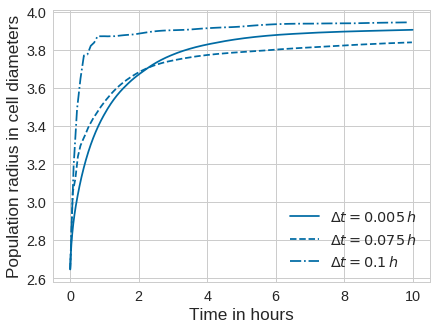

In [19]:
force='cubic'
for i,dt in enumerate(dt_values):
    plt.plot(t_data_values[dt], np.squeeze(radii[force][dt]), label='$\Delta t='+str(dt)+'\,h$',  linestyle=linestyles[i] , color=colors[force])
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_sensitivity_timestep_cubic.pdf', bbox_inches='tight')

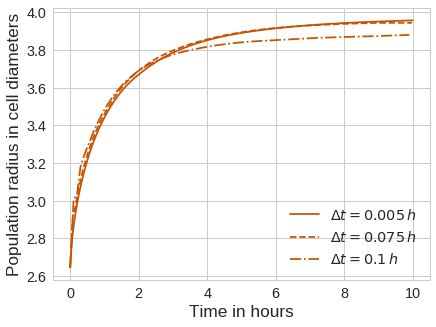

In [20]:
force='pw. quad.'
for i,dt in enumerate(dt_values):
    plt.plot(t_data_values[dt], np.squeeze(radii[force][dt]), label='$\Delta t='+str(dt)+'\,h$', linestyle=linestyles[i], color=colors[force] )
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_sensitivity_timestep_pwq.pdf', bbox_inches='tight')

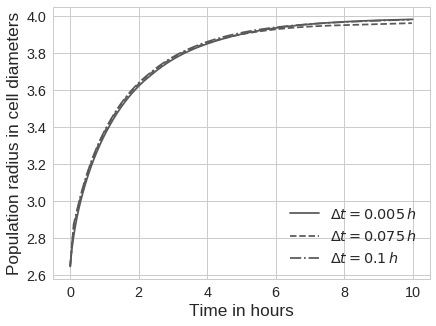

In [21]:
force='GLS'
for i,dt in enumerate(dt_values):
    plt.plot(t_data_values[dt], np.squeeze(radii[force][dt]), label='$\Delta t='+str(dt)+'\,h$',  linestyle=linestyles[i], color=colors[force] )
plt.ylabel('Population radius in cell diameters')

plt.xlabel('Time in hours')
plt.legend()
plt.savefig('radius_sensitivity_timestep_GLS.pdf', bbox_inches='tight')

## Quantify relative differences between the force laws

In [22]:
dt_ref = 0.0005
N_ref = int(1/dt_ref*tf)+1
t_data_ref = np.arange(0, tf, dt_ref)

ref_traj = {}
for force in force_names: 
    print('>'+force)
    history = solvers_ef[force].simulate(sheet, t_data_ref, params[force], {'dt': dt_ref}, seed=seed)
    ref_traj[force] = {
        cell.ID: np.array([cell_list[i].position for cell_list in history])
        for i, cell in enumerate(history[0])
    }

print('Done.')

>cubic
>pw. quad.
>GLS
Done.


In [23]:
# compare PWQ to GLS

error = 0
for ID, tr in ref_traj['pw. quad.'].items():
    ref = ref_traj['GLS'][ID]
    error = error + np.linalg.norm(tr-ref)/np.linalg.norm(ref)
error = error/38.0


In [24]:
error

0.03211905273705174

In [25]:
# compare cubic to GLS

error_cubic = 0
for ID, tr in ref_traj['cubic'].items():
    ref = ref_traj['GLS'][ID]
    error_cubic = error_cubic + np.linalg.norm(tr-ref)/np.linalg.norm(ref)
error_cubic = error_cubic/38.0


error_cubic

0.0391064442874581

In [26]:
# compare cubic to PWQ

error = 0
for ID, tr in ref_traj['cubic'].items():
    ref = ref_traj['pw. quad.'][ID]
    error = error + np.linalg.norm(tr-ref)/np.linalg.norm(ref)
error = error/38.0


error

0.011431391549492341

In [27]:
# compare GLS to PWQ

error = 0
for ID, tr in ref_traj['GLS'].items():
    ref = ref_traj['pw. quad.'][ID]
    error = error + np.linalg.norm(tr-ref)/np.linalg.norm(ref)
error = error/38.0

error

0.0310843065707224